# Liquity provider reward distribution



In [1]:
from _utils import plots

import _sim
from data.exchanges import FTX
from mechanism import *
from mechanism.example_data import *

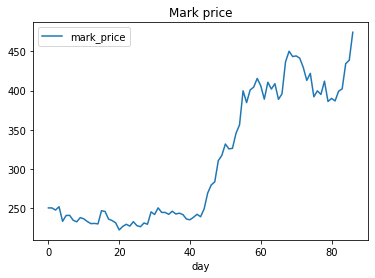

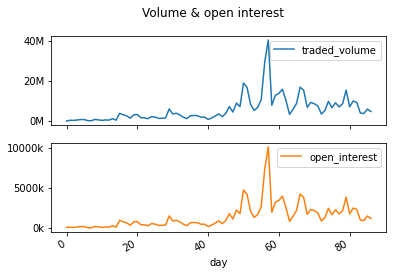

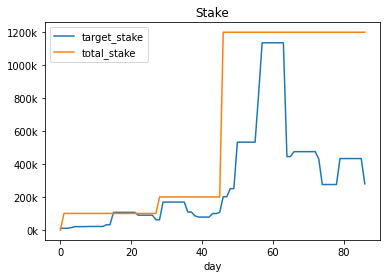

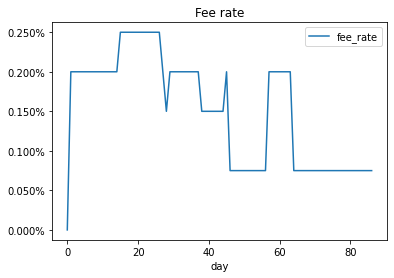

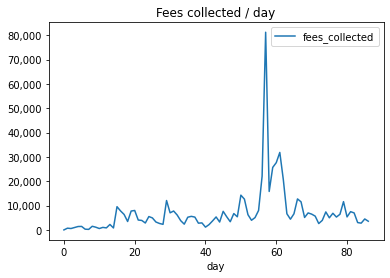

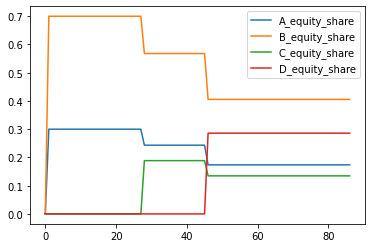

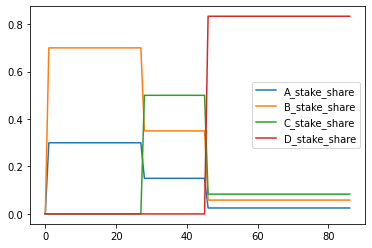

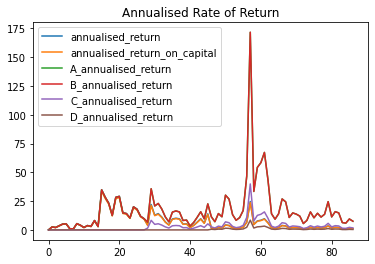

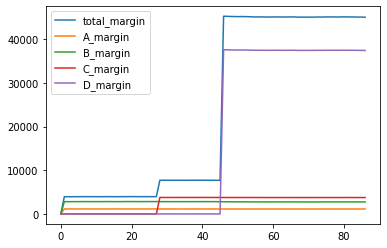

In [2]:
# Load historic data from FTX
ftx = FTX('../data')
data = ftx.get_history(market_id='ETH-0925')

# Create the market
mkt = Market(
    name='FTX_ETH_SEP20', 
    mark_price=data[0]['close'], #use actual market data
    tick_size=1e-2, #this is correct - see get_ftx_data.ipynb
    num_ticks=10,
    liquidity=Liquidity(c2=1.2, v=10, k=1),
    open_interest=0.25*data[0]['volume'],
    risk_model=RiskModel(mu=0.0, sigma=2.0, tau=1.0/60/24/365.25, lambd=0.001))

(lo_empty, lo_smoothed, lf_smoothed, lo_active, lf_active, lo_passive, lf_passive,
 buySideA, sellSideA, buySideB, sellSideB, buySideC, sellSideC, buySideD, sellSideD) = get_order_profiles(mkt)


# Market maker commitments
# Entry format = (day_N, mm_name, stake, fee_bid, buy_profile, sell_profile)
commitments = sorted([
    (1, 'A', 30000, 0.0025, sellSideA, buySideA),
    (1, 'B', 70000, 0.002, sellSideB, buySideB),
    (28, 'C', 100000, 0.0015, sellSideC, buySideC),
    (46, 'D', 1000000, 0.00075, sellSideD, buySideD),
], key=lambda x: x[0])

# open_interest=100000+50000*i
for i in range(len(data)):
    while commitments and commitments[0][0] <= i:
        (_, lp_name, stake, fee_bid, sell_side_shape, buy_side_shape) = commitments.pop(0)
        lp=LiquidityProvider(market=mkt, 
                             name=lp_name, 
                             stake=stake, 
                             fee_bid=fee_bid, 
                             sell_side_shape=sell_side_shape,  
                             buy_side_shape=buy_side_shape)
    mkt=mkt.next(
        traded_volume=data[i]['volume'], 
        open_interest=0.25*data[i]['volume'],  # note we make up OI here as a function of volume, this is not realistic(!)
        mark_price=data[i]['close'])  


# Dump everything to CSV
with open('liquidity_reward_distribution.csv', 'w') as f: mkt.to_csv(output=f)

# Draw some graphs
plots(mkt)

traded_volume,total_stake,A_stake,A_equity_share,B_stake,B_equity_share,C_stake,C_equity_share,D_stake,D_equity_share
250000,100,100,1.0,,,,,,
250000,200,100,0.5,100,0.5,,,,
250000,200,100,0.5,100,0.5,,,,
500000,300,100,0.4,100,0.4,100,0.2,,
500000,800,100,0.2,100,0.2,100,0.1,500,0.5
500000,800,100,0.2,100,0.2,100,0.1,500,0.5
4000000,800,100,0.2,100,0.2,100,0.1,500,0.5


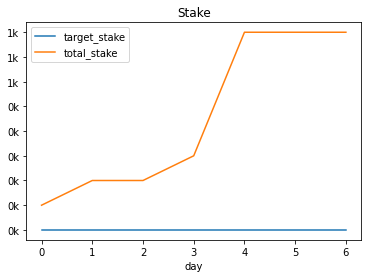

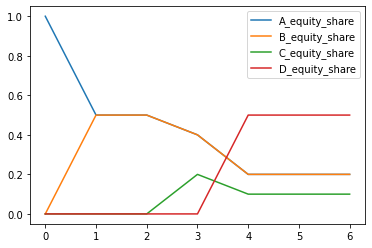

In [3]:
simple_test = Market(
    name='simple', 
    traded_volume=250_000)

# Super simple test setup - either add an LP with given stake or set market size each step
inputs = [
    ('A', 100),
    ('B', 100),
    (None, 500_000),
    ('C', 100),
    ('D', 500),
    (None, 4_000_000),
]

for (n, s) in inputs:
    # Second item in tuple sets new market size (traded_volume)
    if n == None:
        simple_test = simple_test.next(traded_volume=s)
    # Tuple provides liquidity provider name, stake amount
    else:
        LiquidityProvider(market=simple_test, name=n, stake=s)
        simple_test = simple_test.next()

simple_test.to_csv(market_fields=['traded_volume', 'total_stake'], lp_fields=['stake', 'equity_share'])

plots(simple_test, stake_vs_target=True, equity_share=True)